In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy
from torch.utils.data import Dataset
import glob
from PIL import Image
from torch.utils.data import DataLoader

#function to count number of parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

# Load the Dataset 


We can use some PyTorch DataLoader utilities for this that can download, shuffle, normalize data and arrange it in batches. But for now, we are going to create a custom class to load the data.

In [2]:
input_size  = 540*540*3   # images are 224*224 pixels and has 3 channels because of RGB color
output_size = 2      # there are 2 classes---Cat and dog

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 60


# define training and test data directories
data_dir = './data/'
train_dir = os.path.join(data_dir, 'train/')
test_dir = os.path.join(data_dir, 'test/')


#create transformers
train_transform = transforms.Compose([transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
                                    transforms.RandomRotation(degrees=15),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.CenterCrop(size=224),
                                    transforms.ToTensor()])
                                    #transforms.Normalize([0.485, 0.456, 0.406],
                                     #                    [0.229, 0.224, 0.225])])
test_transforms = transforms.Compose([transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
                                    transforms.RandomRotation(degrees=15),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.CenterCrop(size=224),
                                    transforms.ToTensor()])
                                   # transforms.Normalize([0.485, 0.456, 0.406],
                                    #                     [0.229, 0.224, 0.225])])


#train_data = datasets.ImageFolder(train_dir, transform=train_transform)
#test_data = datasets.ImageFolder(test_dir, transform=test_transforms)


# train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
#      num_workers=num_workers, shuffle=True)
# test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
#      num_workers=num_workers)

In [3]:
image_size = (540,540)
image_row_size = image_size[0] * image_size[1]

In [4]:
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]
train_transform = transforms.Compose([
                                transforms.Resize(image_size), 
                                                    transforms.ToTensor(), 
                                transforms.Normalize(mean, std)])
test_transforms = transforms.Compose([
                                transforms.Resize(image_size), 
                                transforms.ToTensor(), 
                                transforms.Normalize(mean, std)])

### Create a dataset class

In [5]:
class datasetloader(Dataset):
    
    def __init__(self, path, transform=None):
        self.classes   = os.listdir(path)
        #self.classes   = [i for i in self.classes if not i.startswith('.')]
        self.path      = [f"{path}/{className}" for className in self.classes]
        self.file_list = [glob.glob(f"{x}/*") for x in self.path]
        self.transform = transform
        
        files = []
        for i, className in enumerate(self.classes):
            print(i,className)
            for fileName in self.file_list[i]:
                files.append([i, className, fileName])
        self.file_list = files
        files = None
        
    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        fileName = self.file_list[idx][2]
        classCategory = self.file_list[idx][0]
        im = Image.open(fileName)
        if self.transform:
            im = self.transform(im)
        return im, classCategory

In [6]:
train_dataset = datasetloader(train_dir, transform=train_transform)
test_dataset = datasetloader(test_dir, transform=test_transforms)

0 dog
1 cat
0 dog
1 cat


In [7]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
     num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, 
     num_workers=num_workers)

In [8]:
def imshow(source):
    plt.figure(figsize=(10,10))
    imt = (source.view(-1, image_size[0], image_size[0]))
    imt = imt.numpy().transpose([1,2,0])
    imt = (std * imt + mean).clip(0,1)
    plt.subplot(1,2,2)
    plt.imshow(imt)

torch.Size([3, 540, 540])

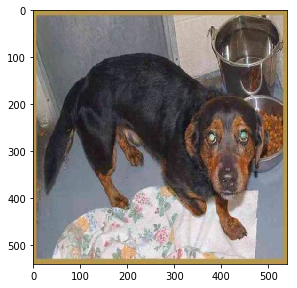

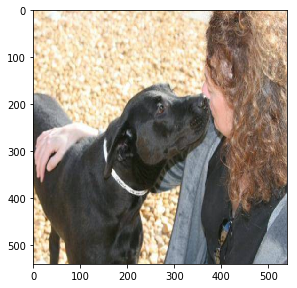

In [9]:
imshow(train_dataset[0][0])
imshow(test_dataset[2][0])
test_dataset[2][0].shape

# Create the model class

In [10]:
class CNN(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(CNN, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=n_feature, kernel_size=5)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.conv3 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.fc1 = nn.Linear(n_feature*64*64, 50)
        self.fc2 = nn.Linear(50, 2)
        
    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, self.n_feature*64*64)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

### Running on a GPU: device string

Switching between CPU and GPU in PyTorch is controlled via a device string, which will seemlessly determine whether GPU is available, falling back to CPU if not:

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [12]:
accuracy_list = []

def train(epoch, model):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        
        #print(data[0].shape)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
def test(model, perm=torch.arange(0, 224*224*3).long()):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss                                                               
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_list.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))

# Train a ConvNet with the same number of parameters

In [13]:
# Training settings 
n_features = 12 # hyperparameter

model_cnn = CNN(input_size, n_features, output_size)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 1):
    train(epoch, model_cnn)
    test(model_cnn)

Number of parameters: 2465888
Train Epoch: 0 [0/22500 (0%)]	Loss: 0.697779
Train Epoch: 0 [6000/22500 (27%)]	Loss: 0.656641
Train Epoch: 0 [12000/22500 (53%)]	Loss: 0.670098
Train Epoch: 0 [18000/22500 (80%)]	Loss: 0.626854

Test set: Average loss: 0.6306, Accuracy: 1544/2500 (62%)

